In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
import sys
sys.path.append('..')
from dataset import batcher

In [30]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [53]:
# Get test split
bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP']
# bands = ['BLUE', 'GREEN', 'RED', 'DELTA_TEMP']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 9)


In [54]:
# Load model
experiments = ['imagery_sample_vgg_regression_MS+DELTA_TEMP']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [55]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-18 14:56:40.178385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[-5.68810105e-01]
 [ 5.25758564e-01]
 [ 6.17285967e-02]
 [-5.54863572e-01]
 [ 2.22569704e+00]
 [-6.91018105e-01]
 [ 5.47146082e-01]
 [ 5.24736285e-01]
 [ 2.58561420e+00]
 [-3.19740385e-01]
 [ 2.80910879e-02]
 [-4.04669464e-01]
 [ 1.11658439e-01]
 [ 2.44158578e+00]
 [-4.53502268e-01]
 [ 8.69229794e-01]
 [-1.18673593e-02]
 [-1.22531295e-01]
 [ 4.37762797e-01]
 [-3.22636813e-01]
 [-4.50196534e-01]
 [ 4.32754964e-01]
 [ 7.45580345e-02]
 [-4.26365048e-01]
 [ 5.42841244e+00]
 [ 4.85638738e-01]
 [ 1.26560584e-01]
 [ 2.25482774e+00]
 [-6.87022328e-01]
 [ 1.30167007e-01]
 [ 2.92911410e-01]
 [-6.11318946e-02]
 [ 2.18801498e+00]
 [-7.33108282e-01]
 [-7.27037072e-01]
 [-5.07936001e-01]
 [-1.35773644e-01]
 [-6.98333859e-01]
 [-9.80046839e-02]
 [ 5.50325103e-02]
 [-3.12601894e-01]
 [ 8.07556733e-02]
 [-6.33151889e-01]
 [-4.32018369e-01]
 [-5.89234114e-01]
 [-2.28437930e-01]
 [-6.07086539e-01]
 [-1.46479160e-01]
 [ 3.30419493e+00]
 [-2.17915177e-01]
 [-5.73903799e-01]
 [-6.40814662e-01]
 [ 5.3166282

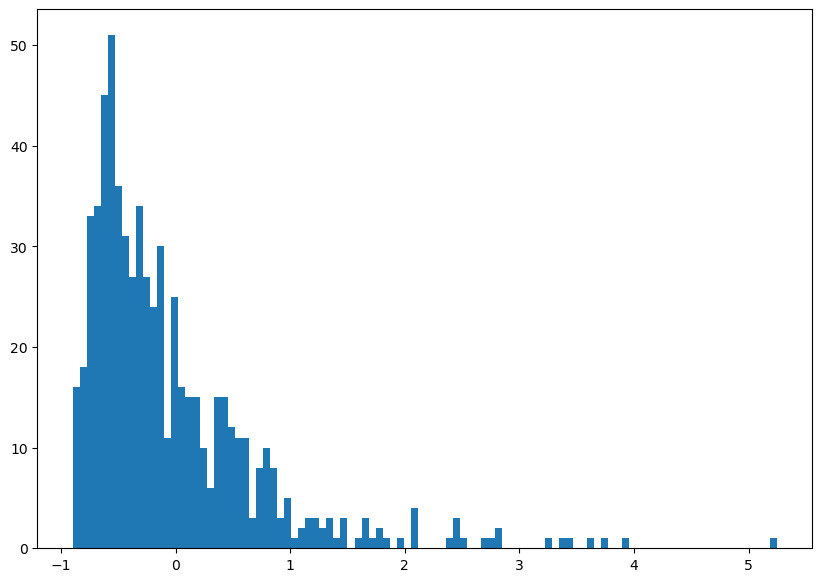

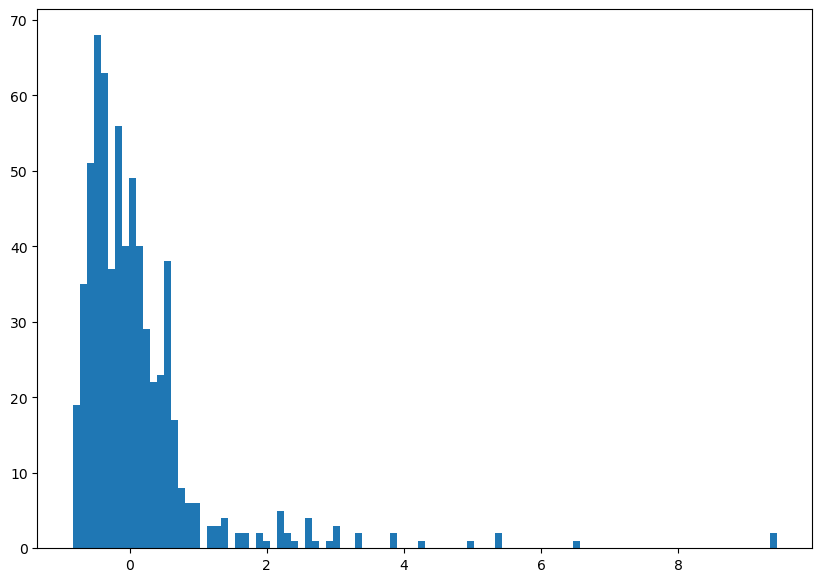

In [56]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

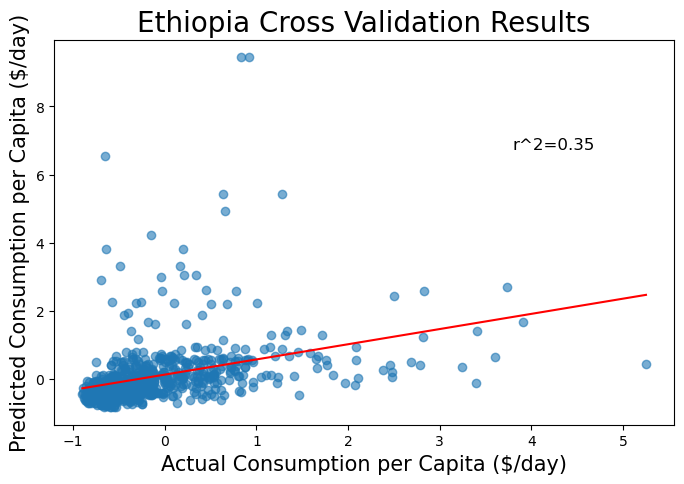

In [57]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()